[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [49]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [50]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [51]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [57]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git
!pip install -q roboflow
!pip install -q supervision
!pip install -q flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [58]:
!apt-get update && apt-get install -y build-essential

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [73.0 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,243 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,836 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,788 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,542 k

In [56]:
!pip install --upgrade pip setuptools whee

  Using cached setuptools-78.1.0-py3-none-any.whl.metadata (6.6 kB)
ERROR: Could not find a version that satisfies the requirement whee (from versions: none)
ERROR: No matching distribution found for whee


In [59]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [53]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-04-15 13:49:25--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg.5’

dog.jpeg.5          100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-04-15 13:49:25 (85.1 MB/s) - ‘dog.jpeg.5’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

In [54]:
!pip install opencv-python-headless
!pip install ultralytics
!pip install supervision

In [55]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = "/content/Rodillaizquierda.png"
image = cv2.imread(image_path)

model = YOLO('/content/YOLOKneeTrained.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

AttributeError: 'AAttn' object has no attribute 'qkv'

## Download dataset from Roboflow Universe

In [ ]:
!pip install roboflow

In [34]:
from roboflow import download_dataset

dataset = download_dataset('https://universe.roboflow.com/knee/ai-knee/dataset/21', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to AI-Knee-21 in yolov8:: 100%|██████████| 4018/4018 [00:00<00:00, 7468.87it/s]


In [35]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [36]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [37]:
!cat {dataset.location}/data.yaml

names:
- Left Knee
- Right Knee
nc: 2
roboflow:
  license: CC BY 4.0
  project: ai-knee
  url: https://universe.roboflow.com/knee/ai-knee/dataset/21
  version: 21
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [38]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

#results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

FileNotFoundError: 'yolov12s.yaml' does not exist

## Evaluate fine-tuned YOLOv12 model

In [91]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch0.jpg
events.out.tfevents.1744637635.9b41cafe0a40.2990.0  train_batch1.jpg
labels_correlogram.jpg				    train_batch2.jpg
labels.jpg					    weights
results.csv


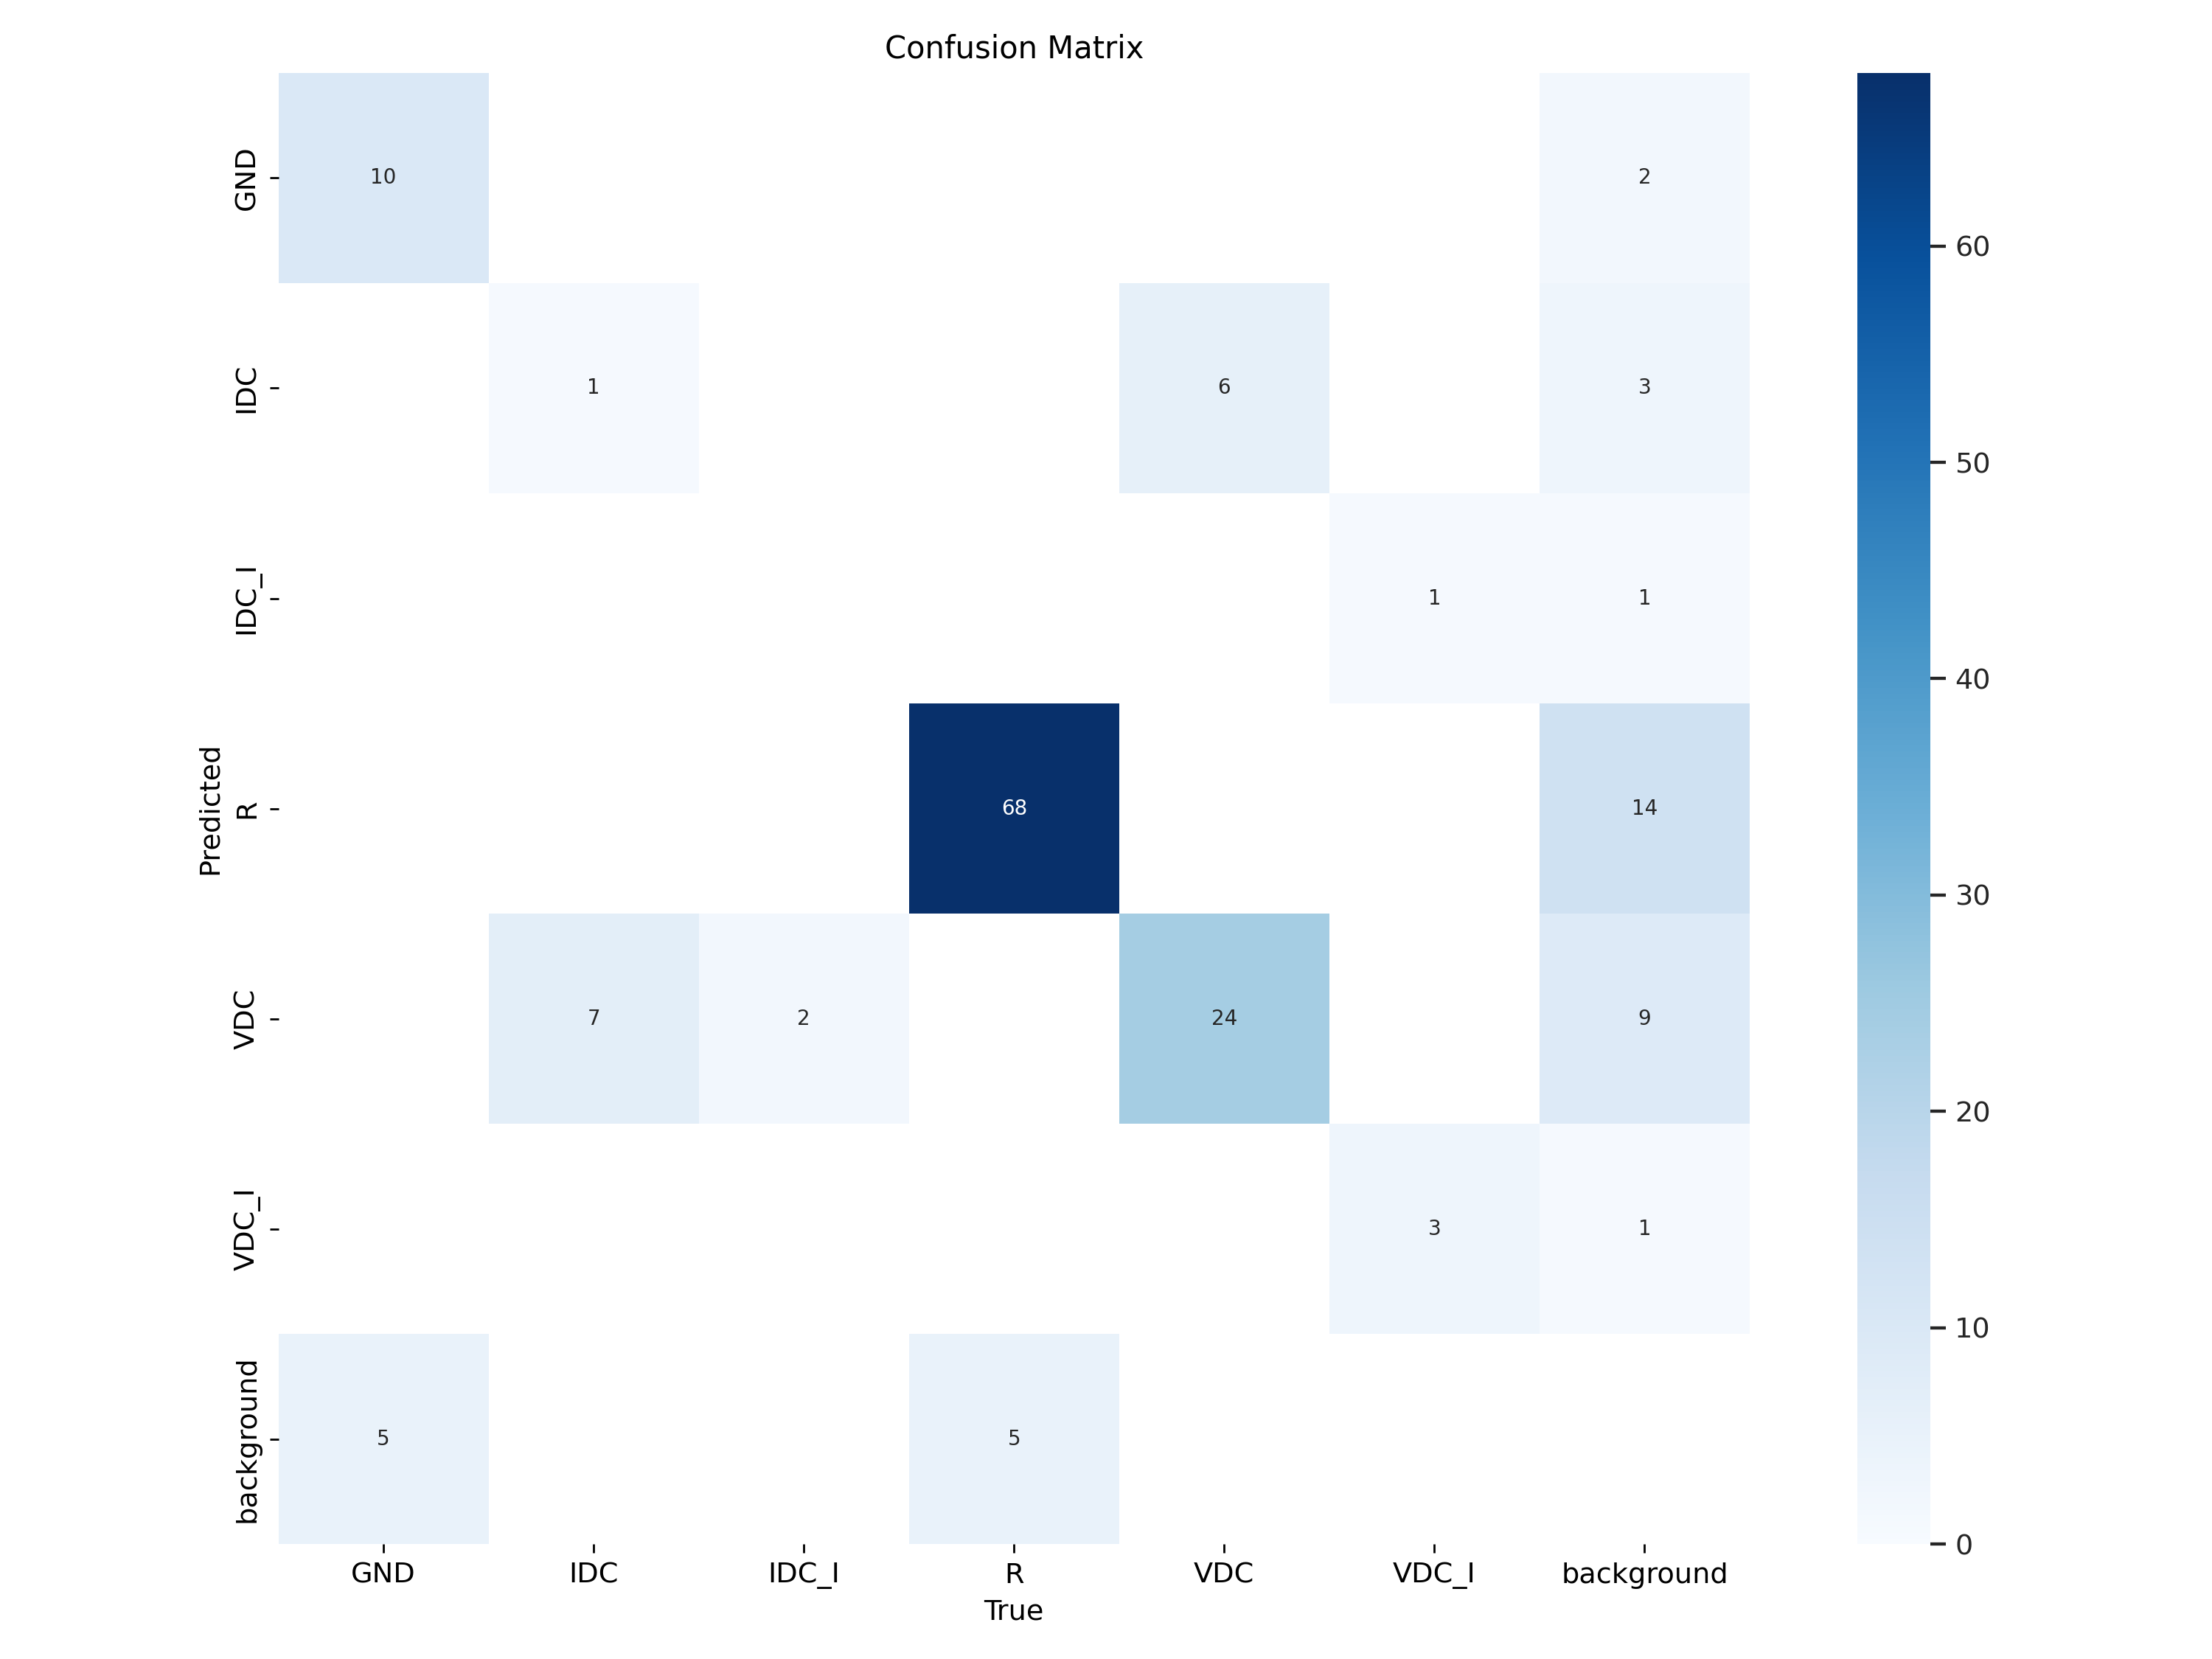

In [92]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=1000)

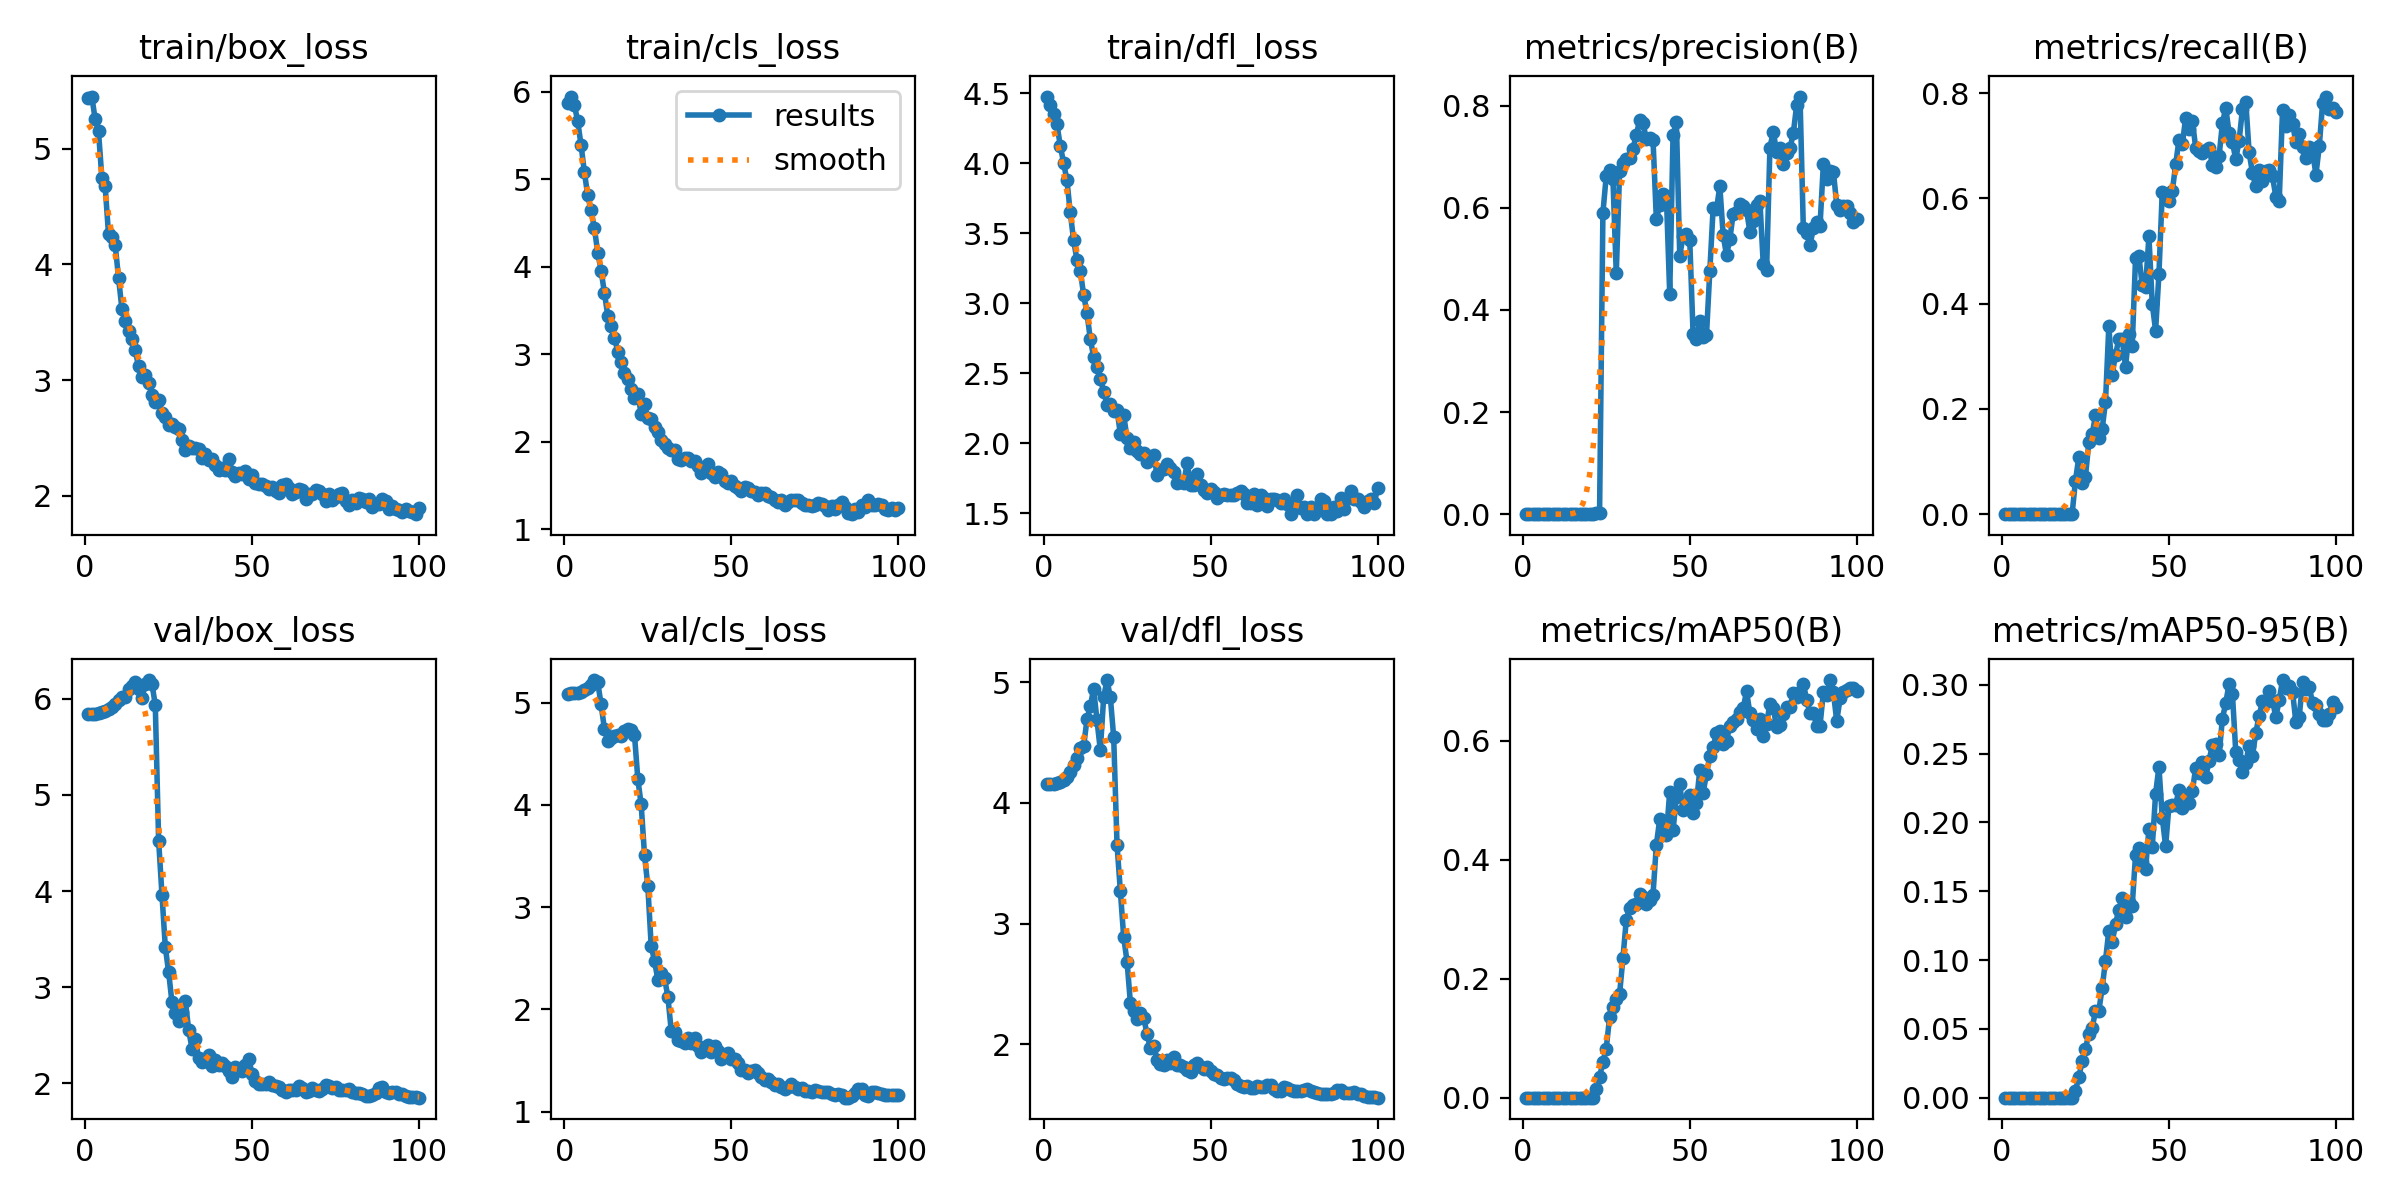

In [93]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/results.png', width=1000)

In [39]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Left Knee', 'Right Knee']

In [40]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/content/YOLOKneeTrained.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

AttributeError: 'AAttn' object has no attribute 'qkv'

In [15]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.46034216181513177
mAP 50 0.48429831692467334
mAP 75 0.48429831692467334


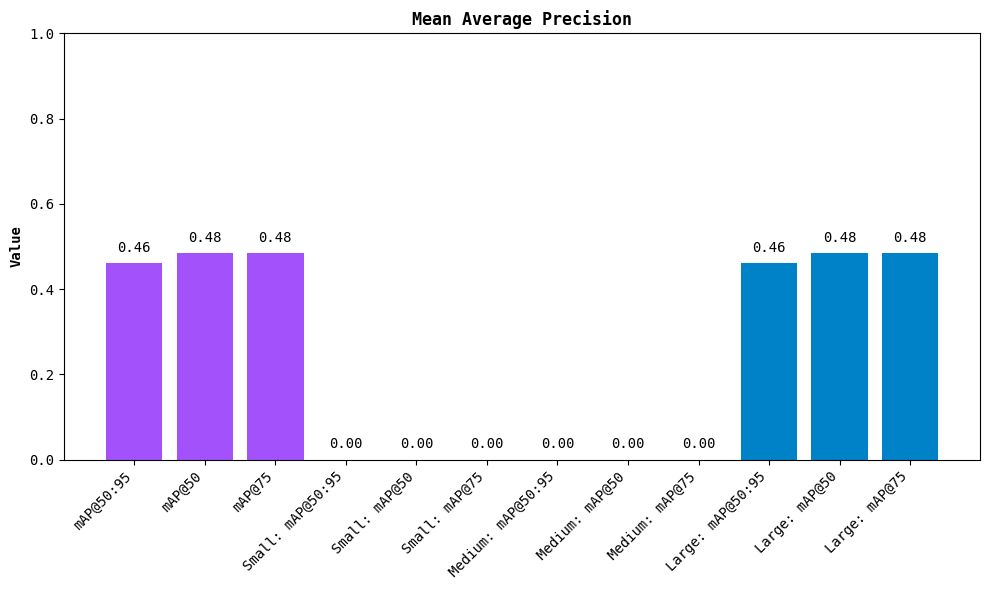

In [16]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [17]:
import supervision as sv

model = YOLO(f'/content/YOLOKneeTrained.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

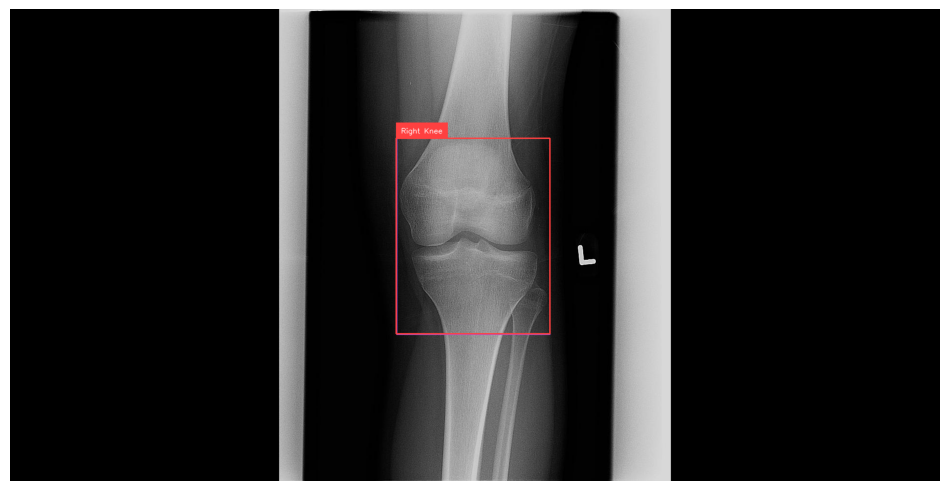

In [18]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

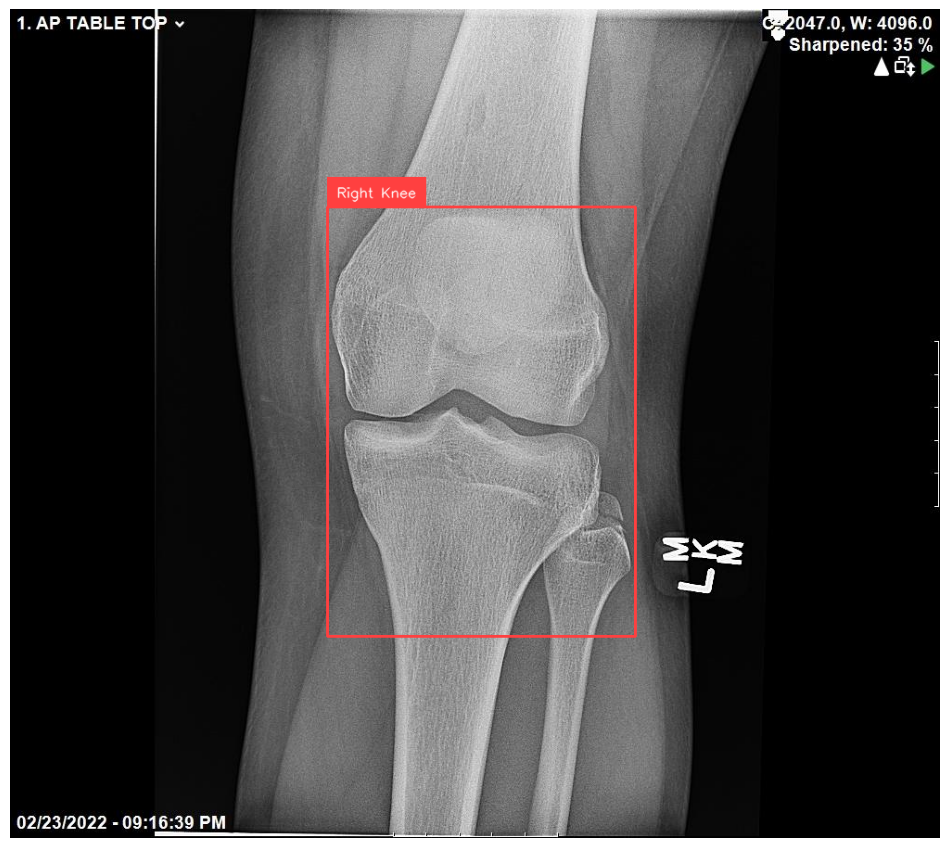

TypeError: 'MeanAveragePrecisionResult' object is not callable

In [19]:
import random
import cv2
import numpy as np
from ultralytics import YOLO
import supervision as sv

# Seleccionar una muestra al azar del dataset (se resta 1 para evitar índice fuera de rango)
i = random.randint(0, len(ds) - 1)
image_path, image, target = ds[i]

# Realizar la inferencia con el modelo YOLO
results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

# Anotar la imagen original con cajas y etiquetas
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

# Convertir detections.xyxy en una lista y luego a un arreglo de NumPy para una iteración correcta
# Esto forzará a que cada elemento sea un arreglo con las coordenadas [x1, y1, x2, y2, ...]
boxes = np.array(list(detections.xyxy))

# Realizar el crop de cada zona detectada
for idx, bbox in enumerate(boxes):
    # Usar solo las primeras 4 coordenadas en caso de que existan scores u otros valores
    x1, y1, x2, y2 = map(int, bbox[:4])

    # Validar que las coordenadas estén dentro de los límites de la imagen
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(image.shape[1], x2)
    y2 = min(image.shape[0], y2)

    # Extraer la región detectada (crop)
    crop = image[y1:y2, x1:x2]

    # Guardar el recorte en un archivo (ej.: "crop_0.png", "crop_1.png", …)
    cv2.imwrite(f'crop_{idx}.png', crop)

    # Mostrar el recorte en una ventana (opcional)
    cv2.imshow(f'Crop {idx}', crop)
    cv2.waitKey(0)

cv2.destroyAllWindows()

In [57]:
!python detect.py --weights --img 640 --conf 0.25 --source '/content/Rodilladerecha.png'  --save-crop

python3: can't open file '/content/detect.py': [Errno 2] No such file or directory


In [20]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
import supervision as sv
import builtins  # Import the builtins module

def detect_and_crop(image_path, output_dir, model_path='yolov12l.pt'):
    # Verificar si el directorio de salida existe, de lo contrario, crearlo
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Cargar la imagen desde el path
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: No se pudo cargar la imagen desde: {image_path}")
        return

    # Inicializar el modelo YOLO (Asegúrate de que el archivo del modelo se encuentre en model_path)
    model = YOLO(f'/content/YOLOKneeTrained.pt')

    # Realizar la inferencia con el modelo (se obtiene el primer resultado)
    results = model(image, verbose=False)[0]

    # Convertir los resultados a detecciones y aplicar NMS (non-maxima suppression)
    detections = sv.Detections.from_ultralytics(results).with_nms()

    # Convertir detections.xyxy a una lista para iterar sobre los bounding boxes
    boxes = list(detections.xyxy)
    if len(boxes) == 0:
        print("No se detectaron objetos en la imagen.")
        return

    # Iterar por cada caja detectada, realizar el crop y guardar la imagen resultante
    for idx, bbox in enumerate(boxes):
        # Extraer las 4 primeras coordenadas en caso de que existan otros valores (ej. confidence, clase, etc.)
        x1, y1, x2, y2 = builtins.map(int, bbox[:4]) # Use builtins.map

        # Ajustar coordenadas para que sean válidas dentro de la imagen
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)

        # Realizar el crop de la región detectada
        crop = image[y1:y2, x1:x2]

        # Definir la ruta de salida para el recorte
        output_path = os.path.join(output_dir, f'crop_{idx}.png')
        cv2.imwrite(output_path, crop)
        print(f"Recorte guardado en: {output_path}")

if __name__ == '__main__':
    # Ejemplo de uso:
    # Especifica el path de la imagen a procesar y el directorio donde se guardarán los recortes.
    image_path = "/content/Rodillaizquierda.png"       # Reemplaza con el path de tu imagen
    output_dir = "/content/"  # Reemplaza con el directorio donde deseas guardar los crops

    detect_and_crop(image_path, output_dir)

Recorte guardado en: /content/crop_0.png


In [21]:
!pip install tensorflow

In [26]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/Densenet1.40.keras')

In [31]:
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    print("No se detectaron GPUs. Se usará CPU.")
else:
    print("GPUs detectadas:", gpus)

GPUs detectadas: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Resto de tu código...

filepath = '/content/crop_0.png'
IMG_SIZE = 224  # Tamaño esperado de entrada para el modelo
IMAGE_CHANNEL = 3  # Número de canales de la imagen (RGB)

def prepare(filepath):
    try:
        # Leer la imagen
        img_array = cv2.imread(filepath)
        if img_array is None:
            raise ValueError(f"No se pudo cargar la imagen desde: {filepath}")

        # Convertir a RGB si fue cargada en escala de grises
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        # Cambiar el tamaño de la imagen al tamaño esperado por el modelo
        resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        # Normalizar los valores de píxeles entre 0 y 1
        normalized_array = resized_array / 255.0

        # Agregar dimensión adicional para batch
        return normalized_array.reshape(1, IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)
    except Exception as e:
        print("Error al preparar la imagen:", str(e))
        return None

# Preparar la imagen de rodilla
Rodilla = prepare(filepath)

if Rodilla is not None:
    # Realizar predicción
    prediction = model.predict(Rodilla)  # Asegúrate de que 'model' es el modelo de clasificación correctamente cargado

    # Obtener la etiqueta con mayor probabilidad
    predicted_label = np.argmax(prediction)

    # Mostrar el resultado
    print(f'La A.I. predice la etiqueta de la rodilla como: {predicted_label}')

    # Visualizar la imagen con el resultado
    plt.imshow(cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB))
    plt.title(f"Predicción: {predicted_label}")
    plt.axis("off")
    plt.show()
else:
    print("No se pudo realizar la predicción debido a un error en la preparación de la imagen.")


InvalidArgumentError: Graph execution error:

Detected at node functional_1/densenet169_1/conv1_conv_1/convolution defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-27-80470fa44777>", line 39, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 249, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 104, in predict_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py", line 1305, in conv

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 331, in conv

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 304, in _conv

No DNN in stream executor.
	 [[{{node functional_1/densenet169_1/conv1_conv_1/convolution}}]] [Op:__inference_one_step_on_data_distributed_29375]